In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4 as nc

import sys
sys.path.append('../../')

from parallel_get_xy_poly import ParallelCoord
from nc_explorer import NcExplorer
from tsgen import TsGenerator

gpc = ParallelCoord()
tsg = TsGenerator()
exp = NcExplorer()

sen3r-NcExplorer: from mpl_toolkits.basemap import Basemap FAILED!You can still proceed without plotting any maps.
Declaring class instance from: SEN3R:Nc_Explorer
Input NetCDF file folder not set. Proceed at your own risk.
Declaring class instance from: SEN3R:Nc_Explorer
Input NetCDF file folder not set. Proceed at your own risk.


## TESTING SUN AND OBS ANGLES FOR GLINT

In [2]:
def get_glint(df):
    """
    Calculates glint angle based on paper:
    An Enhanced Contextual Fire Detection Algorithm for MODIS
    https://www.sciencedirect.com/science/article/pii/S0034425703001846
    https://doi.org/10.1016/S0034-4257(03)00184-6
    """

    df['GLINT'] = np.degrees(np.arccos(np.cos(np.deg2rad(df['OZA:float'])) *
                                       np.cos(np.deg2rad(df['SZA:float'])) -
                                       np.sin(np.deg2rad(df['OZA:float'])) *
                                       np.sin(np.deg2rad(df['SZA:float'])) *
                                       np.cos(np.deg2rad(abs(df['SAA:float'] - df['OAA:float'])))))

    # excel version
    # =GRAUS(ACOS(COS(RADIANOS(OZA))*COS(RADIANOS(SZA))-SEN(RADIANOS(OZA))*SEN(RADIANOS(SZA))*COS(RADIANOS(ABS(SAA-OAA)))))

    return df

In [3]:
# Just a small refactoring of the old code
def get_x_y(lat_arr, lon_arr, lat, lon):

    grid = np.concatenate([lat_arr[..., None], lon_arr[..., None]], axis=2)
    
    vector = np.array([lat, lon]).reshape(1, 1, -1)
    subtraction = vector - grid 
    dist = np.linalg.norm(subtraction, axis=2)
    result = np.where(dist == dist.min())
    target_x_y = result[0][0], result[1][0]
    
    return target_x_y
    
# considering that creating the 2D grid consumes memory, we will get all coordinates in just one pass
def get_x_y_poly(lat_arr, lon_arr, polyline):
    grid = np.concatenate([lat_arr[..., None], lon_arr[..., None]], axis=2)
    
    # Polyline is a GeoJSON coordinate array
    polyline = polyline.squeeze()
    
    # loop through each vertice
    vertices = []
    for i in range(polyline.shape[0]):
        
        vector = np.array([polyline[i, 1], polyline[i, 0]]).reshape(1, 1, -1)
        subtraction = vector - grid 
        dist = np.linalg.norm(subtraction, axis=2)
        result = np.where(dist == dist.min())
        target_x_y = [result[0][0], result[1][0]]
        
        vertices.append(target_x_y)
    return np.array(vertices)

def bbox(vertices):
    "Get the bounding box of the vertices. Just for visualization purposes"
    ymin = np.min(vertices[:,0])
    ymax = np.max(vertices[:,0])    
    xmin = np.min(vertices[:,1])
    xmax = np.max(vertices[:,1])        
    return xmin, xmax, ymin, ymax


In [4]:
# WFR - UNIX
path = Path('/d_drive_data/S3/L2_WFR/S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3')

# Load image folder to SEN3R:NcExplorer.py
exp.nc_folder = path

# Create a list with all valid NetCDF4 files
ncfs = exp.get_valid_band_files(rad_only=False)
ncfs

['chl_nn.nc',
 'chl_oc4me.nc',
 'geo_coordinates.nc',
 'instrument_data.nc',
 'iop_nn.nc',
 'iwv.nc',
 'Oa01_reflectance.nc',
 'Oa02_reflectance.nc',
 'Oa03_reflectance.nc',
 'Oa04_reflectance.nc',
 'Oa05_reflectance.nc',
 'Oa06_reflectance.nc',
 'Oa07_reflectance.nc',
 'Oa08_reflectance.nc',
 'Oa09_reflectance.nc',
 'Oa10_reflectance.nc',
 'Oa11_reflectance.nc',
 'Oa12_reflectance.nc',
 'Oa16_reflectance.nc',
 'Oa17_reflectance.nc',
 'Oa18_reflectance.nc',
 'Oa21_reflectance.nc',
 'par.nc',
 'tie_geometries.nc',
 'tie_geo_coordinates.nc',
 'tie_meteo.nc',
 'time_coordinates.nc',
 'trsp.nc',
 'tsm_nn.nc',
 'wqsf.nc',
 'w_aer.nc']

In [5]:
geo_coord = nc.Dataset(path/'geo_coordinates.nc')
g_lat = geo_coord['latitude'][:]
g_lon = geo_coord['longitude'][:]

tie_geo = nc.Dataset(path/'tie_geo_coordinates.nc')
t_lat = tie_geo['latitude'][:]
t_lon = tie_geo['longitude'][:]

tie_geometries = nc.Dataset(path/'tie_geometries.nc')
OAA = tie_geometries['OAA'][:]
OZA = tie_geometries['OZA'][:]
SAA = tie_geometries['SAA'][:]
SZA = tie_geometries['SZA'][:]

## READ BUFFER POLYGON

In [6]:
import json

with open('/home/dvdgmf/qgis_out/manacapuru_buffer.geojson') as f:
    data = json.load(f)

for feature in data['features']:
    poly = feature['geometry']['coordinates']    
poly = np.array(poly[0])

In [7]:
%time g_vertices = gpc.parallel_get_xy_poly(g_lat, g_lon, poly)

CPU times: user 98.6 ms, sys: 197 ms, total: 296 ms
Wall time: 4.65 s


In [8]:
%time t_vertices = gpc.parallel_get_xy_poly(t_lat, t_lon, poly)

CPU times: user 22 ms, sys: 65.5 ms, total: 87.5 ms
Wall time: 114 ms


In [9]:
bbox(g_vertices)

(2328, 2653, 672, 865)

In [10]:
bbox(t_vertices)

(36, 41, 671, 866)

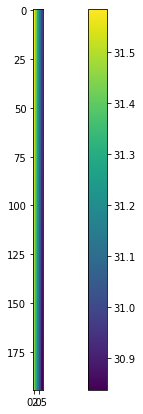

In [11]:
band = SZA
bname = 'SZA'
vertices = t_vertices

xmin, xmax, ymin, ymax = bbox(vertices)

%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 7]
plt.plot(vertices[:,1],vertices[:,0]*-1,c='k')
plt.imshow(band.data[ymin:ymax, xmin:xmax])
plt.colorbar()
plt.show()

In [12]:
# Generate extraction mask
from skimage.draw import polygon

img = np.zeros(band.shape)
rr, cc = polygon(vertices[:,0], vertices[:,1], band.shape)
img[rr, cc] = 1

# Apply the mask and get the reflectance
syn_val = band[rr, cc]

# Create a DF from the extracted reflectance
custom_subset = {bname:syn_val.data,'x':rr,'y':cc}
df = pd.DataFrame(custom_subset)
df.head()

,SZA,x,y
0,30.825381,671,41
1,30.820967,677,41
2,30.820232,678,41
3,30.819496,679,41
4,30.818762,680,41


In [13]:
len(df)

307

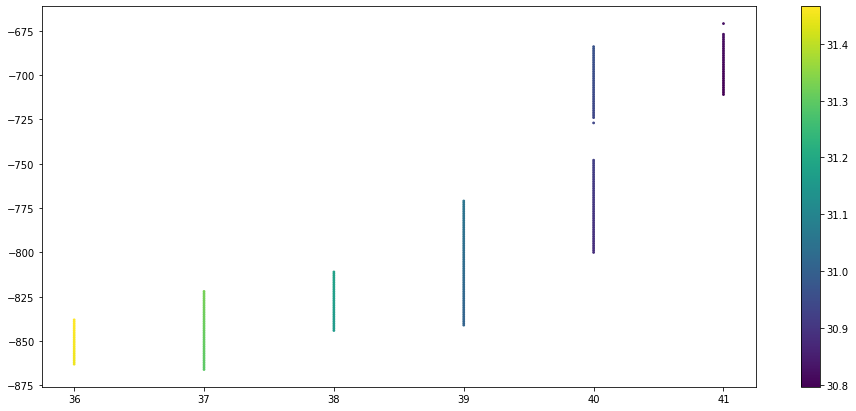

In [14]:
# plt.plot(vertices[:,1],vertices[:,0]*-1,c='k')
plt.scatter(df['y'],df['x']*-1,c=df['SZA'],s=3)
plt.colorbar()

In [15]:
g_lon.shape

(4091, 4865)

In [16]:
t_lon.shape

(4091, 77)

In [17]:
g_lon[0:5,0:5]

masked_array(
  data=[[-66.348819, -66.346453, -66.344087, -66.341721, -66.339355],
        [-66.349395, -66.347029, -66.344663, -66.342298, -66.339932],
        [-66.349972, -66.347606, -66.34524 , -66.342874, -66.340508],
        [-66.350548, -66.348182, -66.345816, -66.34345 , -66.341084],
        [-66.351124, -66.348758, -66.346392, -66.344026, -66.34166 ]],
  mask=False,
  fill_value=1e+20)

In [18]:
t_lon[0:5,0:5]

masked_array(
  data=[[-66.348811, -66.19739 , -66.045968, -65.894546, -65.743123],
        [-66.349387, -66.197966, -66.046545, -65.895123, -65.7437  ],
        [-66.349964, -66.198543, -66.047121, -65.895699, -65.744277],
        [-66.35054 , -66.199119, -66.047698, -65.896276, -65.744854],
        [-66.351116, -66.199696, -66.048275, -65.896853, -65.745431]],
  mask=False,
  fill_value=1e+20)

In [19]:
SZA[0:5,0:5]

masked_array(
  data=[[37.542435, 37.391041, 37.239675, 37.088336, 36.937026],
        [37.541677, 37.390281, 37.238913, 37.087572, 36.936259],
        [37.540919, 37.389521, 37.23815 , 37.086807, 36.935492],
        [37.540161, 37.388761, 37.237388, 37.086043, 36.934726],
        [37.539405, 37.388002, 37.236627, 37.085279, 36.93396 ]],
  mask=False,
  fill_value=1e+20)

In [20]:
np.set_printoptions(linewidth=120) # default is 75

mtx = SZA[0:5,0:5].copy()
np.resize(mtx,(5,10))

masked_array(
  data=[[37.542435, 37.391041, 37.239675, 37.088336, 36.937026, 37.541677, 37.390281, 37.238913, 37.087572, 36.936259],
        [37.540919, 37.389521, 37.23815 , 37.086807, 36.935492, 37.540161, 37.388761, 37.237388, 37.086043, 36.934726],
        [37.539405, 37.388002, 37.236627, 37.085279, 36.93396 , 37.542435, 37.391041, 37.239675, 37.088336, 36.937026],
        [37.541677, 37.390281, 37.238913, 37.087572, 36.936259, 37.540919, 37.389521, 37.23815 , 37.086807, 36.935492],
        [37.540161, 37.388761, 37.237388, 37.086043, 36.934726, 37.539405, 37.388002, 37.236627, 37.085279, 36.93396 ]],
  mask=False,
  fill_value=1e+20)

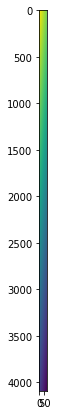

In [44]:
plt.imshow(t_lat)
plt.show()

In [31]:
print(g_lon.shape,t_lon.shape)

(4091, 4865) (4091, 77)


In [45]:
from skimage.transform import resize
rszd_t_lon = resize(t_lon, (g_lon.shape[0], g_lon.shape[1]), anti_aliasing=False)
rszd_t_lat = resize(t_lat, (g_lat.shape[0], g_lat.shape[1]), anti_aliasing=False)
# Resize Sun Zenith Angle using the geo_coordinates.nc file dimensions: (4091, 4865)
rszd_SZA = resize(SZA, (g_lon.shape[0], g_lon.shape[1]), anti_aliasing=False)

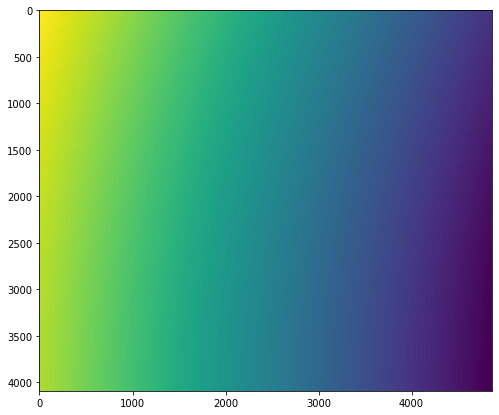

In [46]:
plt.imshow(rszd_SZA)
plt.show()

In [48]:
%time rszd_t_vertices = gpc.parallel_get_xy_poly(rszd_t_lat, rszd_t_lon, poly)

CPU times: user 126 ms, sys: 382 ms, total: 508 ms
Wall time: 4.59 s


In [50]:
rszd_t_vertices

array([[ 863, 2333],
       [ 843, 2329],
       [ 838, 2333],
       [ 822, 2383],
       [ 822, 2383],
       [ 811, 2439],
       [ 812, 2471],
       [ 798, 2491],
       [ 771, 2523],
       [ 749, 2536],
       [ 727, 2543],
       [ 694, 2553],
       [ 684, 2574],
       [ 677, 2604],
       [ 671, 2637],
       [ 695, 2651],
       [ 703, 2641],
       [ 711, 2596],
       [ 724, 2579],
       [ 770, 2561],
       [ 770, 2561],
       [ 800, 2544],
       [ 800, 2544],
       [ 817, 2521],
       [ 834, 2511],
       [ 834, 2511],
       [ 841, 2486],
       [ 843, 2456],
       [ 844, 2430],
       [ 860, 2377],
       [ 866, 2339],
       [ 863, 2333]])

In [51]:
bbox(rszd_t_vertices)

(2329, 2651, 671, 866)

In [54]:
xmin, xmax, ymin, ymax = bbox(vertices)

In [62]:
rszd_SZA[xmin:xmax, ymin:ymax]

array([[34.65659111, 34.65413998, 34.65168885, ..., 34.18598653, 34.18353557, 34.18108461],
       [34.65621598, 34.65376483, 34.65131369, ..., 34.18560936, 34.18315839, 34.18070742],
       [34.65584085, 34.65338969, 34.65093853, ..., 34.18523136, 34.18278039, 34.18032942],
       ...,
       [34.54643745, 34.5439829 , 34.54152835, ..., 34.07516948, 34.07271501, 34.07026053],
       [34.54612132, 34.54366676, 34.54121219, ..., 34.07485148, 34.07239701, 34.06994253],
       [34.54580532, 34.54335076, 34.54089619, ..., 34.07453348, 34.07207901, 34.06962453]])

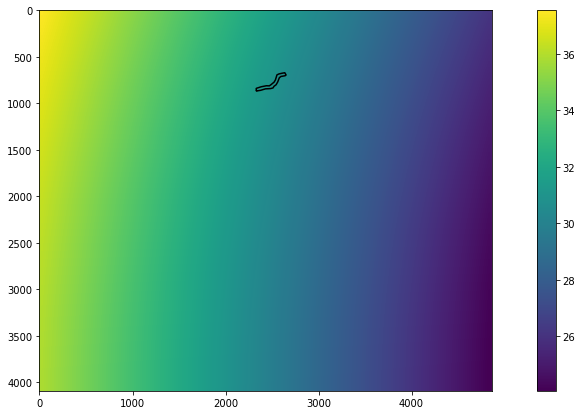

In [70]:
band = rszd_SZA
bname = 'SZA'
vertices = rszd_t_vertices

xmin, xmax, ymin, ymax = bbox(vertices)

%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 7]
plt.imshow(band)
plt.plot(vertices[:,1],vertices[:,0],c='k')
plt.colorbar()
plt.show()

In [71]:
# Generate extraction mask
from skimage.draw import polygon

img = np.zeros(band.shape)
rr, cc = polygon(vertices[:,0], vertices[:,1], band.shape)
img[rr, cc] = 1

# Apply the mask and get the reflectance
syn_val = band[rr, cc]

# Create a DF from the extracted reflectance
custom_subset = {bname:syn_val.data,'x':rr,'y':cc}
df = pd.DataFrame(custom_subset)
df.head()

,SZA,x,y
0,30.788262,671,2637
1,30.799535,672,2632
2,30.797133,672,2633
3,30.794731,672,2634
4,30.792329,672,2635


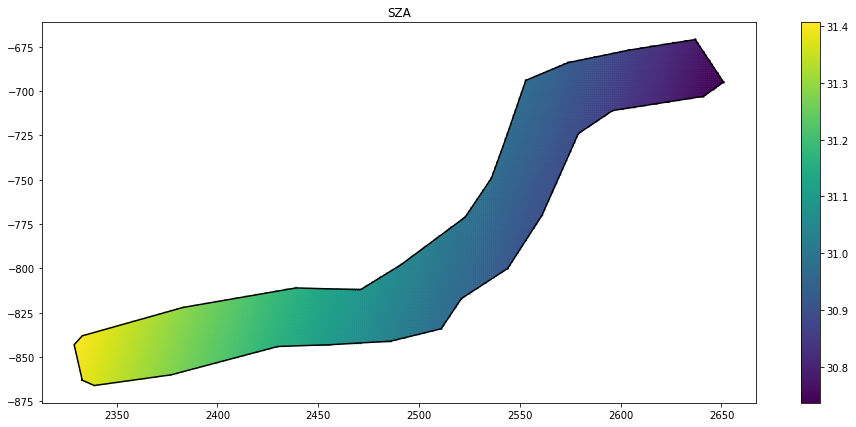

In [73]:
plt.title(bname)
plt.plot(vertices[:,1],vertices[:,0]*-1,c='k')
plt.scatter(df['y'],df['x']*-1,c=df['SZA'],s=3)
plt.colorbar()